In [1]:
from deepCR import deepCR
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import cm
import h5py
import numpy as np
import os

# DeepCR Quickstart

In [2]:
data_dir = os.environ.get('DEEPCR_DIR')
!ls $data_dir

jdba2sooq_flc.fits


In [3]:
image1 = fits.getdata(data_dir + 'jdba2sooq_flc.fits')
print(image1.shape)
image = image1[:256,:256]
print(image.shape)

(2048, 4096)
(256, 256)


In [4]:
gray = cm.get_cmap('gray_r')

In [5]:
print(image)

[[42.28243  38.904068 25.735434 ... 53.539692 33.32361  30.478346]
 [43.418453 41.592106 27.598694 ... 35.54825  32.72727  36.49637 ]
 [53.350258 25.814383 35.532906 ... 44.662865 51.444855 30.921324]
 ...
 [38.185905 30.90197  44.670544 ... 27.150616 41.92302  40.785843]
 [31.331957 40.321552 31.6171   ... 27.320856 28.28168  46.591114]
 [16.586002 36.79833  38.817642 ... 36.483208 30.300848 26.049236]]


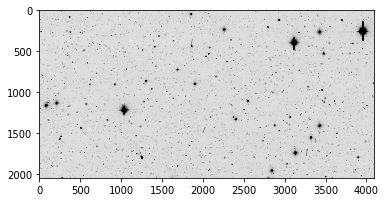

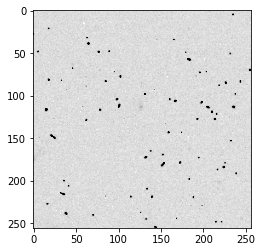

In [6]:
plt.imshow(image1, cmap = gray, vmin = 0, vmax = 250)
plt.show()
plt.imshow(image, cmap = gray,vmin = 0, vmax = 250, clim = (0,350))
plt.show()

In [8]:
mdl = deepCR(mask="ACS-WFC-F606W-2-32",
             inpaint="ACS-WFC-F606W-2-32",
             device="CPU")

In [9]:
# mask, cleaned_image = mdl.clean(image, threshold = 0.5) #Kernel crashes
# mask = mdl.clean(image, threshold = 0.5, inpaint = False) #Kernel crashes
# prob_mask = mdl.clean(image, binary=False) #Kernel crashes
# mask, cleaned_image = mdl.clean(image, threshold = 0.5, n_jobs=-1) #Kernel crashes
# mask, cleaned_image = mdl.clean(image, threshold = 0.5, inpaint = False, segment = True) #Kernel crashes

# DESI image

In [10]:
def printname(name):
    print(name)
    return None

In [11]:
desi_dir = os.environ.get('GQPMC_DIR')
desi_image = h5py.File(desi_dir+'/mini_mocha/bgs.exposure.surveysim.150s.v0p4.sample.hdf5','r')

In [12]:
desi_image.visit(printname)

airmass
moon_alt
moon_ill
moon_sep
seeing
sky
sun_alt
sun_sep
texp_total
transp
wave


In [13]:
desi_image['texp_total'][...]

array([1870.,  520., 1120., 1130.,  870., 1370.,  980., 1610.],
      dtype=float32)

# CCD Data Reduction Guide Walkthrough

In [60]:
%matplotlib inline
from photutils.aperture import EllipticalAperture
from convenience_functions import show_image

In [62]:
synthetic_image = np.zeros([2000,2000])

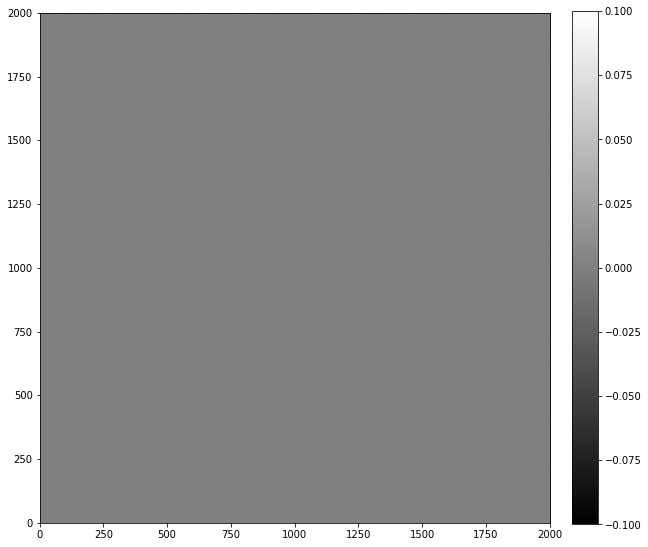

In [63]:
show_image(synthetic_image, cmap = 'gray')

#### Adding read noise

In [64]:
def read_noise(image, amount, gain = 1):
    shape = image.shape
#     np.random.seed(1)
    noise = np.random.normal(scale = amount/gain, size = shape)
    return noise

<Figure size 432x288 with 0 Axes>

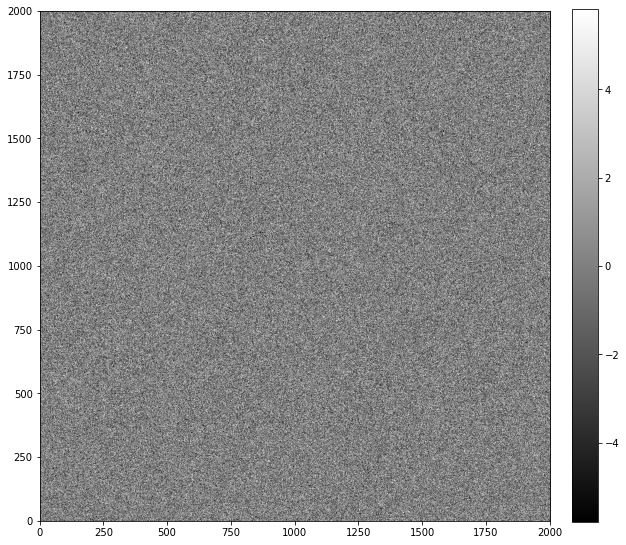

In [68]:
plt.figure()
noise_im = synthetic_image+read_noise(synthetic_image,5)
show_image(noise_im, cmap = 'gray')

#### Adding bias

The bias value is roughly the same across the CCD chip, though it's not uncommon to have "bad" columns and pixels in which the bias level is consistently offset from the rest of the chip.

In [69]:
def bias(image, value, realistic = False):
    bias_im = np.zeros_like(image) + value
    
    if realistic:
        shape = image.shape
        number_of_columns = 5
        rng = np.random.RandomState(seed = 8392)
        columns = rng.randint(0,shape[1],size = number_of_columns)
        col_pattern = rng.randint(0,int(0.1*value), size = shape[0])
        
        for c in columns:
            bias_im[:,c] = value + col_pattern
    
    return bias_im

Text(0.5, 1.0, 'Bias alone, bad columns included')

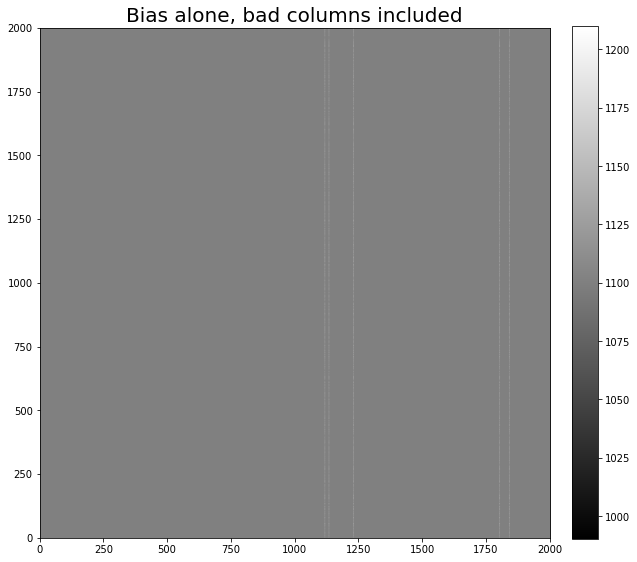

In [70]:
bias_only = bias(synthetic_image, 1100, realistic = True)
show_image(bias_only, cmap = 'gray', figsize=(10,10))
plt.title('Bias alone, bad columns included', fontsize = 20)

Text(0.5, 1.0, 'Realistic bias frame (includes read noise)')

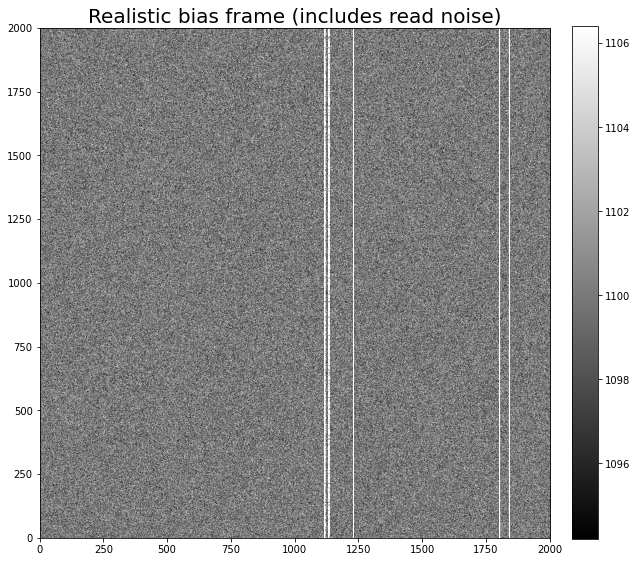

In [71]:
bias_noise_im = noise_im + bias_only
show_image(bias_noise_im, cmap = 'gray', figsize=(10,10))
plt.title('Realistic bias frame (includes read noise)', fontsize = 20)

#### Dark current

In [76]:
def dark_current(image, current, exposure_time, gain = 1.0, hot_pixels = False):
    base_current = current * exposure_time / gain
    
    dark_im = np.random.poisson(base_current, size = image.shape)
    
    if hot_pixels:
        y_max, x_max = dark_im.shape
        
        n_hot = int(0.0001 * x_max * y_max)
        
        rng = np.random.RandomState(16201649)
        hot_x = rng.randint(0, x_max, size = n_hot)
        hot_y = rng.randint(0, y_max, size = n_hot)
        
        hot_current = 10000 * current
        
        dark_im[[hot_y, hot_x]] = hot_current * exposure_time / gain
        
    return dark_im

<ipython-input-76-b32369f175af>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dark_im[[hot_y, hot_x]] = hot_current * exposure_time / gain


Text(0.5, 1.0, 'Dark current only, 0.1 $e^-$/sec/pix\n100 sec exposure')

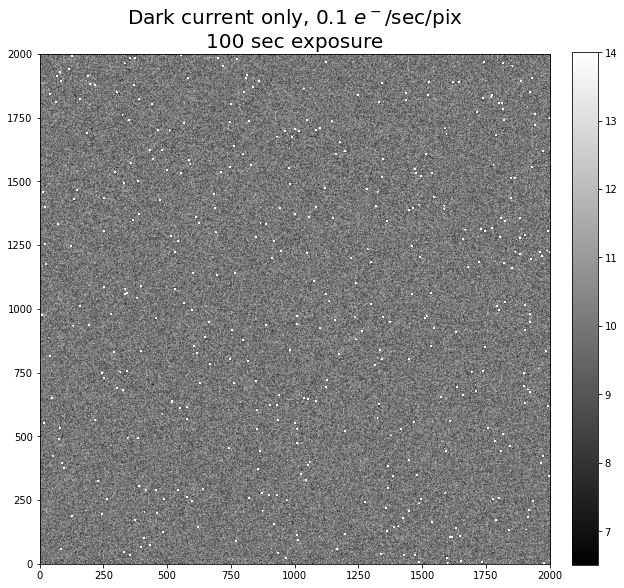

In [87]:
dark_exposure = 100
dark_cur = 0.1
dark_only = dark_current(synthetic_image, dark_cur, dark_exposure, hot_pixels = True)
show_image(dark_only, cmap = 'gray')
title_string = 'Dark current only, {dark_cur} $e^-$/sec/pix\n{dark_exposure} sec exposure'.format(dark_cur=dark_cur, dark_exposure=dark_exposure)
plt.title(title_string, fontsize='20')

Note that the central value of the image colorbar is 10, the product of the dark current and the exposure time.

Text(0.5, 1.0, 'Realistic dark frame \n(with bias, read noise)')

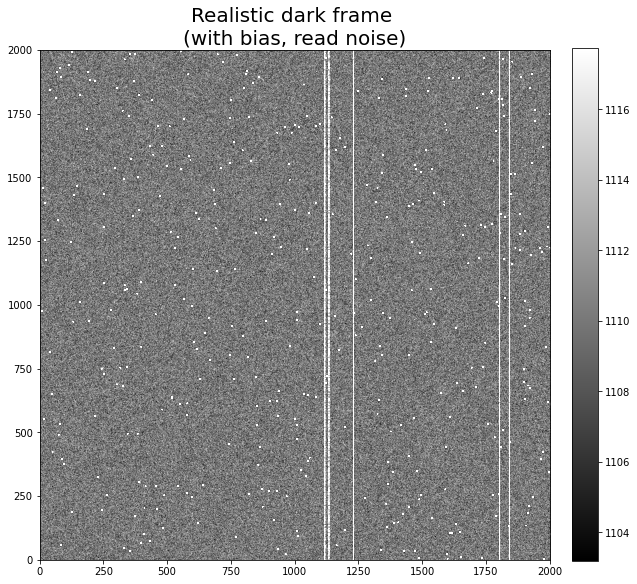

In [88]:
dark_bias_noise_im = bias_noise_im + dark_only
show_image(dark_bias_noise_im, cmap = 'gray')
plt.title('Realistic dark frame \n(with bias, read noise)', fontsize='20')